In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import robust_scene_change_detect.models as models

from py_utils import utils_img, utils_torch

---
new data

In [ ]:
root = "./google_map_screenshots"

t0_0 = plt.imread(os.path.join(root, "00.2013.03.png"))[..., :3]
t1_0 = plt.imread(os.path.join(root, "00.2024.07.png"))[..., :3]

t0_1 = plt.imread(os.path.join(root, "01.2013.02.png"))[..., :3]
t1_1 = plt.imread(os.path.join(root, "01.2023.05.png"))[..., :3]

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(t0_0)
ax[0, 1].imshow(t1_0)
ax[1, 0].imshow(t0_1)
ax[1, 1].imshow(t1_1)

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
roi = np.load(os.path.join(root, "roi.npy"))

kwargs = {
    "layer": [1, 1, 1],  # white color
    "ratio": 0.3,
    "mask": roi,
}

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(utils_img.overlay_image(t0_0, **kwargs))
ax[0, 1].imshow(utils_img.overlay_image(t1_0, **kwargs))
ax[1, 0].imshow(utils_img.overlay_image(t0_1, **kwargs))
ax[1, 1].imshow(utils_img.overlay_image(t1_1, **kwargs))

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
kwargs = {
    "layer": [0, 0, 0],  # black color
    "ratio": 0.0,
    "mask": roi,
}

masked_t0_0 = utils_img.overlay_image(t0_0, **kwargs)
masked_t1_0 = utils_img.overlay_image(t1_0, **kwargs)
masked_t0_1 = utils_img.overlay_image(t0_1, **kwargs)
masked_t1_1 = utils_img.overlay_image(t1_1, **kwargs)

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_0)
ax[0, 1].imshow(masked_t1_0)
ax[1, 0].imshow(masked_t0_1)
ax[1, 1].imshow(masked_t1_1)

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
# we have pre-processed the screenshots as dinov2 only accepts 14n * 14m

H, W = masked_t0_0.shape[:2]

print(H, W)
print(H % 14, W % 14)

---
get model

In [ ]:
# ---- Uncomment one of these ----

# main model
model = models.get_model_from_pretrained("dino_2Cross_CMU")
# model = models.get_model_from_pretrained("dino_2Cross_DiffCMU")
# model = models.get_model_from_pretrained("dino_2Cross_PSCD")

# ablation models
# model = models.get_model_from_pretrained("resnet_2Cross_CMU")
# model = models.get_model_from_pretrained("resnet_2Cross_PSCD")

# model = models.get_model_from_pretrained("dino_1Cross_CMU")
# model = models.get_model_from_pretrained("dino_CoAttn_CMU")
# model = models.get_model_from_pretrained("dino_TemporalAttn_CMU")
# model = models.get_model_from_pretrained("dino_MTF_CMU")

# --------------------------------

model = model.eval()

# change upsampling size based on the input image size
model.module.upsample.size = (952, 1918)

In [ ]:
# inference on 00
tensor_0 = torch.from_numpy(masked_t0_0).permute(2, 0, 1).unsqueeze(0)
tensor_0 = tensor_0.float().cuda()

tensor_1 = torch.from_numpy(masked_t1_0).permute(2, 0, 1).unsqueeze(0)
tensor_1 = tensor_1.float().cuda()

with torch.no_grad():
    pred_0 = model(tensor_0, tensor_1)  # 1, H, W, 2
    pred_1 = model(tensor_1, tensor_0)  # 1, H, W, 2

    pred_0 = torch.argmax(pred_0, dim=-1).squeeze().cpu().numpy()
    pred_1 = torch.argmax(pred_1, dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_0)
ax[0, 1].imshow(masked_t1_0)
ax[1, 0].imshow(utils_img.overlay_image(masked_t0_0, [1, 0, 0], mask=pred_0))
ax[1, 1].imshow(utils_img.overlay_image(masked_t1_0, [1, 0, 0], mask=pred_1))

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("change map on 00.2013.03")
ax[1, 1].set_title("change map on 00.2024.07")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
# inference on 01
tensor_0 = torch.from_numpy(masked_t0_1).permute(2, 0, 1).unsqueeze(0)
tensor_0 = tensor_0.float().cuda()

tensor_1 = torch.from_numpy(masked_t1_1).permute(2, 0, 1).unsqueeze(0)
tensor_1 = tensor_1.float().cuda()

with torch.no_grad():
    pred_0 = model(tensor_0, tensor_1)  # 1, H, W, 2
    pred_1 = model(tensor_1, tensor_0)  # 1, H, W, 2

    pred_0 = torch.argmax(pred_0, dim=-1).squeeze().cpu().numpy()
    pred_1 = torch.argmax(pred_1, dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_1)
ax[0, 1].imshow(masked_t1_1)
ax[1, 0].imshow(utils_img.overlay_image(masked_t0_1, [1, 0, 0], mask=pred_0))
ax[1, 1].imshow(utils_img.overlay_image(masked_t1_1, [1, 0, 0], mask=pred_1))


ax[0, 0].set_title("01.2013.02")
ax[0, 1].set_title("01.2023.05")
ax[1, 0].set_title("change map on 01.2013.02")
ax[1, 1].set_title("change map on 01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

---
Your own model and images

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from skimage.transform import resize

import robust_scene_change_detect.models as models

from py_utils import utils_img, utils_torch

In [3]:
# Load your fine-tuned model
# Step 1: Load base model architecture
my_model = models.get_model_from_pretrained("dino_2Cross_DiffCMU")

# Step 2: Load your fine-tuned checkpoint
checkpoint_path = "/home/divit/projects/Robust-Scene/Robust-Scene-Change-Detection/output/2025-08-21.10-52-58/best.val.pth"
checkpoint = torch.load(checkpoint_path, map_location='cuda')

def remove_module_prefix(state_dict):
    """Remove 'module.' prefix from keys if present (DataParallel training)"""
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v  # Remove 'module.' prefix
        else:
            new_state_dict[k] = v
    return new_state_dict

# Step 3: Apply fine-tuned weights to the model
try:
    # Try different checkpoint structure possibilities
    if 'model_state_dict' in checkpoint:
        state_dict = remove_module_prefix(checkpoint['model_state_dict'])
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded from 'model_state_dict'")
    elif 'state_dict' in checkpoint:
        state_dict = remove_module_prefix(checkpoint['state_dict'])
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded from 'state_dict'")
    elif 'model' in checkpoint:
        state_dict = remove_module_prefix(checkpoint['model'])
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded from 'model'")
    else:
        # If checkpoint is directly the state dict
        state_dict = remove_module_prefix(checkpoint)
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded direct state dict")
    
    # Report any missing or unexpected keys
    if missing_keys:
        print(f"⚠️  Missing keys: {len(missing_keys)} (these will use pretrained weights)")
    if unexpected_keys:
        print(f"⚠️  Unexpected keys: {len(unexpected_keys)} (these will be ignored)")
        
    my_model = my_model.eval()
    my_model = my_model.cuda()
    print("🎉 Fine-tuned model loaded successfully on top of dino_2Cross_DiffCMU!")
    
    # Show training info if available
    if 'epoch' in checkpoint:
        print(f"📊 Trained for {checkpoint['epoch']} epochs")
    if 'best_metric' in checkpoint:
        print(f"📈 Best validation metric: {checkpoint['best_metric']:.4f}")
        
except Exception as e:
    print(f"❌ Error loading fine-tuned weights: {e}")
    print("\n🔍 Checkpoint structure:")
    print("Available keys:", list(checkpoint.keys()))
    
    # Fallback to pretrained model
    print("🔄 Using pretrained model instead...")
    my_model = my_model.eval().cuda()

Using cache found in /home/divit/.cache/torch/hub/facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


<All keys matched successfully>
✓ Loaded from 'model'
⚠️  Missing keys: 378 (these will use pretrained weights)
⚠️  Unexpected keys: 28 (these will be ignored)
🎉 Fine-tuned model loaded successfully on top of dino_2Cross_DiffCMU!
📊 Trained for 12 epochs


Image dimensions: 1600x1021
H % 14: 4, W % 14: 13


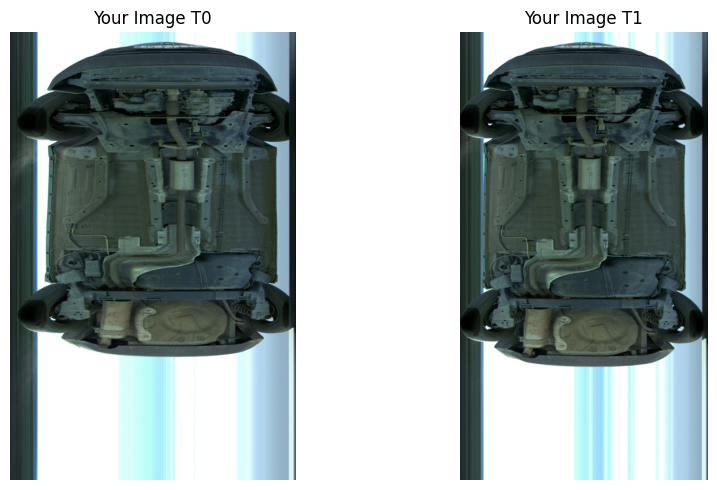

In [ ]:
# Load your own images (without ROI masking)
# Replace these paths with your own image paths
my_image_root = "/home/divit/projects/photos/original"  # Change this to your image directory

# Load your image pair
my_t0 = plt.imread(os.path.join(my_image_root, "in.jpg"))[..., :3]  # Replace with your image names
my_t1 = plt.imread(os.path.join(my_image_root, "out.jpg"))[..., :3]  # Replace with your image names

print(f"Original image dimensions: {my_t0.shape[:2]}")

# Resize images to make dimensions divisible by 14 (for DinoV2)
def resize_to_multiple_of_14(image):
    h, w = image.shape[:2]
    # Calculate new dimensions that are multiples of 14
    new_h = ((h // 14) + (1 if h % 14 != 0 else 0)) * 14
    new_w = ((w // 14) + (1 if w % 14 != 0 else 0)) * 14
    
    # Resize using matplotlib (simple nearest neighbor)
    from skimage.transform import resize
    resized = resize(image, (new_h, new_w), preserve_range=True, anti_aliasing=True)
    return resized.astype(image.dtype)

# Resize both images
my_t0 = resize_to_multiple_of_14(my_t0)
my_t1 = resize_to_multiple_of_14(my_t1)

# Display your images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(my_t0)
ax[1].imshow(my_t1)
ax[0].set_title("Your Image T0 (Resized)")
ax[1].set_title("Your Image T1 (Resized)")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

# Check image dimensions (should be divisible by 14 for DinoV2)
H, W = my_t0.shape[:2]
print(f"Resized image dimensions: {H}x{W}")
print(f"H % 14: {H % 14}, W % 14: {W % 14}")
print(f"✓ Ready for DinoV2!" if H % 14 == 0 and W % 14 == 0 else "❌ Still not compatible")

In [5]:
# Inference on your images (no ROI masking)
# Update model upsampling size for your images
my_model.module.upsample.size = (H, W)

# Convert to tensors
my_tensor_0 = torch.from_numpy(my_t0).permute(2, 0, 1).unsqueeze(0)
my_tensor_0 = my_tensor_0.float().cuda()

my_tensor_1 = torch.from_numpy(my_t1).permute(2, 0, 1).unsqueeze(0)
my_tensor_1 = my_tensor_1.float().cuda()

# Run inference
with torch.no_grad():
    my_pred_0 = my_model(my_tensor_0, my_tensor_1)  # 1, H, W, 2
    my_pred_1 = my_model(my_tensor_1, my_tensor_0)  # 1, H, W, 2

    my_pred_0 = torch.argmax(my_pred_0, dim=-1).squeeze().cpu().numpy()
    my_pred_1 = torch.argmax(my_pred_1, dim=-1).squeeze().cpu().numpy()

# Visualize results
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].imshow(my_t0)
ax[0, 1].imshow(my_t1)
ax[1, 0].imshow(utils_img.overlay_image(my_t0, [1, 0, 0], mask=my_pred_0))
ax[1, 1].imshow(utils_img.overlay_image(my_t1, [1, 0, 0], mask=my_pred_1))

ax[0, 0].set_title("Your Image T0")
ax[0, 1].set_title("Your Image T1")
ax[1, 0].set_title("Change map on T0")
ax[1, 1].set_title("Change map on T1")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

AssertionError: Input image height 1600 is not a multiple of patch height 14

---
Debug: Check what's inside your checkpoint file